# Showcase for ptdalgorithms

Python header:

In [1]:
%load_ext rpy2.ipython

from IPython.display import Image
from graphviz import Digraph
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('ticks')
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

R header:

In [2]:
%%R
library(tidyverse)
library(devtools)
#remove.packages("ptdalgorithms")
devtools::install_github("TobiasRoikjer/PtDAlgorithms")
library(ptdalgorithms)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: Indlæser krævet pakke: usethis

R[write to console]: Skipping install of 'ptdalgorithms' from a github remote, the SHA1 (d022b128) has not changed since last install.
  Use `force = TRUE` to force installation



# IM model

Each state has the following three properties:
1. nr decendants in population 1
2. nr decendants in population 2
3. what population the lineage is currently in

In [3]:
%%R
Rcpp::sourceCpp("./isolation_migration.cpp")

ld: warning: -pie being ignored. It is only used when linking a main executable


In [4]:
%%R
graph <- construct_im_graph(4,4,1,1,0.1,0.1)
vertices_length(graph)

[1] 1432


In [5]:
# %%R
# for (i in 1:vertices_length(graph)) { edges(vertex_at(graph, i)) }

In [ ]:
%%R -o states -o parents -o children -o rates 

states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state ))

parents <- c()
children <- c()
rates <- c()
for (i in 1:vertices_length(graph)) {
    for (edge in edges(vertex_at(graph, i))) {
        parents <- c(parents, i)
        children <- c(children, edge$child$index)
        rates <- c(rates, edge$weight)
    }
}

In [ ]:
def plot_graph(states, parents, children, rates, constrained=True, size='10'):

    states = np.array(states)
    # states = list(zip(list(locus1[0]), list(locus2[0]) ))#, list(pop[0])))

    parents = [int(i-1) for i in parents]
    children = [int(i-1) for i in children]
    
    constrained = constrained and 'true' or 'false'
    
    dot = Digraph()
    dot.node('S', 'S')
    for i in range(1, len(states)):
        dot.node(str(i), str(states[i]))
    dot.edge('S', str(1))        
    for p, c, r in zip(parents, children, rates):
        if p > 0:
            dot.edge(str(p), str(c), constraint=constrained, label=str(r))

    dot.graph_attr['size'] = size                
    return dot

plot_graph(states, parents, children, rates)

Comparing results for numerical accuracy for an "infinite" IM stage

In [ ]:
%%R -o matrix_expectation -o algorithm_expectation -o simulation_expectation -o distribution_expectation 

n1 <- 4
n2 <- 4

g <- construct_im_graph(n1,n2,1,1,0.1,0.1)

expected_visits <- rep(0, vertices_length(g))
ctx <- distribution_context(g,1000)
while (distribution_context_state(ctx)$cdf < 0.9999) {
  distribution_context_step(ctx)
}
expected_visits <- distribution_context_accumulated_visiting_time(ctx)

distribution_expectation <- matrix(nrow=n1+1,ncol=n2+1)
algorithm_expectation <- matrix(nrow=n1+1,ncol=n2+1)
matrix_expectation <- matrix(nrow=n1+1,ncol=n2+1)
simulation_expectation <- matrix(nrow=n1+1,ncol=n2+1)
PH <- graph_as_matrix(g)
U <- solve(-PH$SIM)
set.seed(1234)

for (i in 0:n1) {
  for (j in 0:n2) {
    matrix_expectation[i+1,j+1] <-PH$IPV %*% U%*%diag(PH$states[,(matrix_index(i,j,0,n1,n2)+1)]+PH$states[,(matrix_index(i,j,1,n1,n2)+1)])%*%rep(1,length(PH$IPV))
    algorithm_expectation[i+1, j+1]<- expectation(g, rewards_at(g, i,j,n1,n2))
    distribution_expectation[i+1,j+1] <- sum(expected_visits * rewards_at(g, i,j,n1,n2))
    simulation_expectation[i+1, j+1]<- mean(rph(1000000, g, rewards_at(g, i,j,n1,n2)))
  }
}

print(sum(abs(matrix_expectation - algorithm_expectation)))
print(sum(abs(matrix_expectation - simulation_expectation)))
print(sum(abs(matrix_expectation - distribution_expectation)))

In [ ]:
plt.subplots(1, 1, figsize=(7, 5))
ax = sns.heatmap(matrix_expectation - distribution_expectation, cmap="viridis_r", 
                annot=True
                )
ax.invert_yaxis()

The complete IM model with a split time and ancestral population:

In [ ]:
%%time
%%R 

# parameters
n1 <- 4
n2 <- 4
m1 <- 1
m2 <- 1
split_t <- 1.5 # time in whatever unit used to scale transition probs (N generations)

# build im graph
im_g <- construct_im_graph(n1,n2,1,1,0.1,0.1)
cat(vertices_length(im_g), "\n")

# create ancestral graph
a_g <- construct_ancestral_graph(n1,n2,1)
cat(vertices_length(a_g), "\n")


In [6]:
%%time
%%R -o n1 -o n2 -o m12 -o m12 -o split_t -o im_expectation -o a_expectation

# parameters
n1 <- 10
n2 <- 10
m12 <- 0.005
m21 <- 2
p1 <- 2
p2 <- 1
pa <- 4
split_t <- 3 # time in whatever unit used to scale transition probs (N generations)

# build im graph
im_g <- construct_im_graph(n1, n2, p1, p2, m12, m21)
cat(vertices_length(im_g), "\n")

im_expected_visits <- accumulated_visiting_time(im_g, split_t)

# create ancestral graph
a_g <- construct_ancestral_graph(n1, n2, pa)
cat(vertices_length(a_g), "\n")

# find probabilities of starting at each state in ancestral graph
start_prob <- start_prob_from_im(a_g, im_g, im_expected_visits)

# compute expectations for each graph
im_expectation <- matrix(nrow=n1+1,ncol=n2+1)
a_expectation <- matrix(nrow=n1+1,ncol=n2+1)
for (i in 0:n1) {
  for (j in 0:n2) {
    im_expectation[i+1,j+1] <- sum(im_expected_visits * rewards_at(im_g, i,j,n1,n2))
    a_expectation[i+1, j+1]<- sum(start_prob * expected_waiting_time(a_g, rewards_at(a_g, i,j,n1,n2)))
  }
}

6373414 
59522 


INFO: building reward compute graph...


CPU times: user 51min 32s, sys: 2min, total: 53min 32s
Wall time: 55min


In [8]:
## pd.DataFrame(im_expectation).to_hdf(f'im_{int(n1)}_{int(n2)}_{float(m1)}_{float(m2)}_{float(split_t)}.h5', key='df', format='table')
pd.DataFrame(a_expectation).to_hdf(f'a_{int(n1)}_{int(n2)}.h5', key='df', format='table')

Expectation for inifinte IM stage:

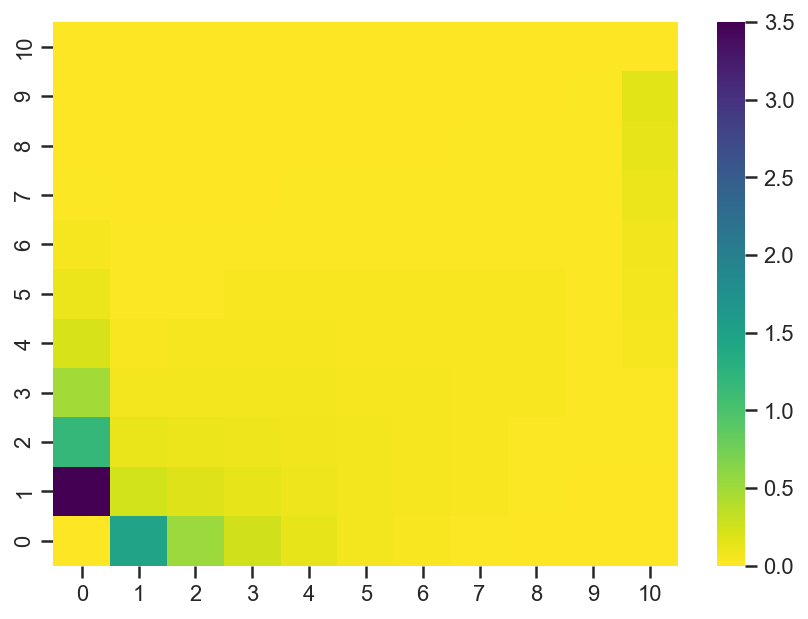

In [9]:
plt.subplots(1, 1, figsize=(7, 5))
ax = sns.heatmap(pd.DataFrame(im_expectation), cmap="viridis_r", 
#                annot=True
                )
ax.invert_yaxis()
plt.savefig('im_stage.pdf')

Expectation for panmictic ancestral population:

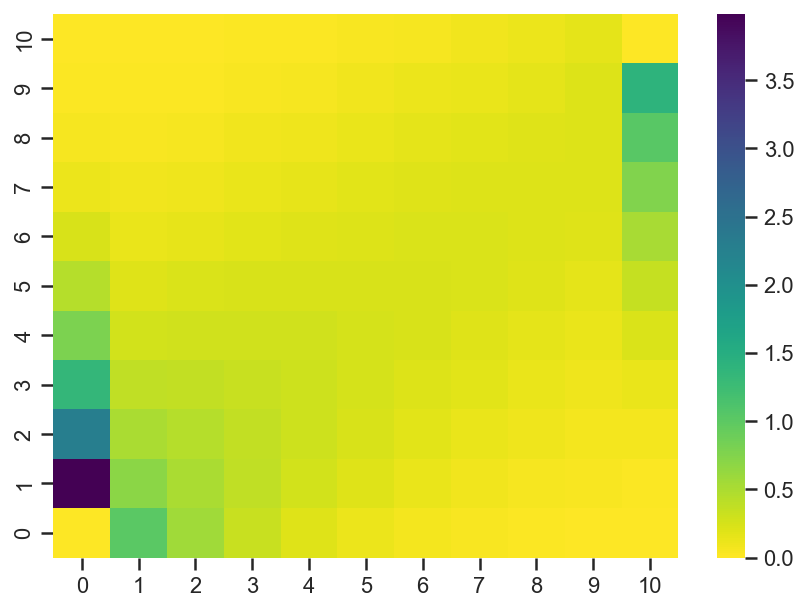

In [10]:
plt.subplots(1, 1, figsize=(7, 5))
ax = sns.heatmap(a_expectation, cmap="viridis_r", 
#                annot=True
                 
                )
ax.invert_yaxis()
plt.savefig('a_stage.pdf')

Expectation for combined IM model with split time:

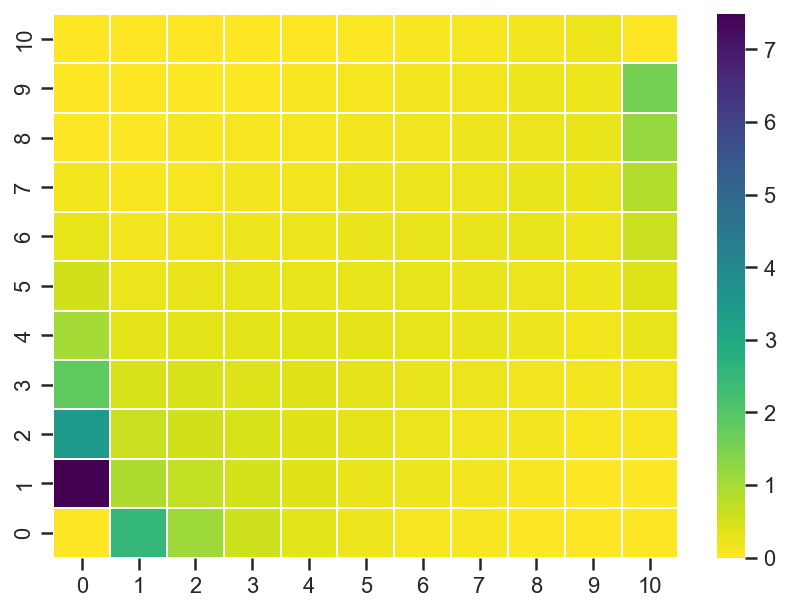

In [22]:
plt.subplots(1, 1, figsize=(7, 5))
ax = sns.heatmap(im_expectation + a_expectation, cmap="viridis_r", 
                # annot=True,
                 linewidths=1,
                 linecolor='white'
                )
ax.invert_yaxis()
plt.savefig(f"im_{n1}_{n1}_{m12}_{m12}_{split_t}.pdf")
plt.savefig(f"im_{n1}_{n1}_{m12}_{m12}_{split_t}.png")

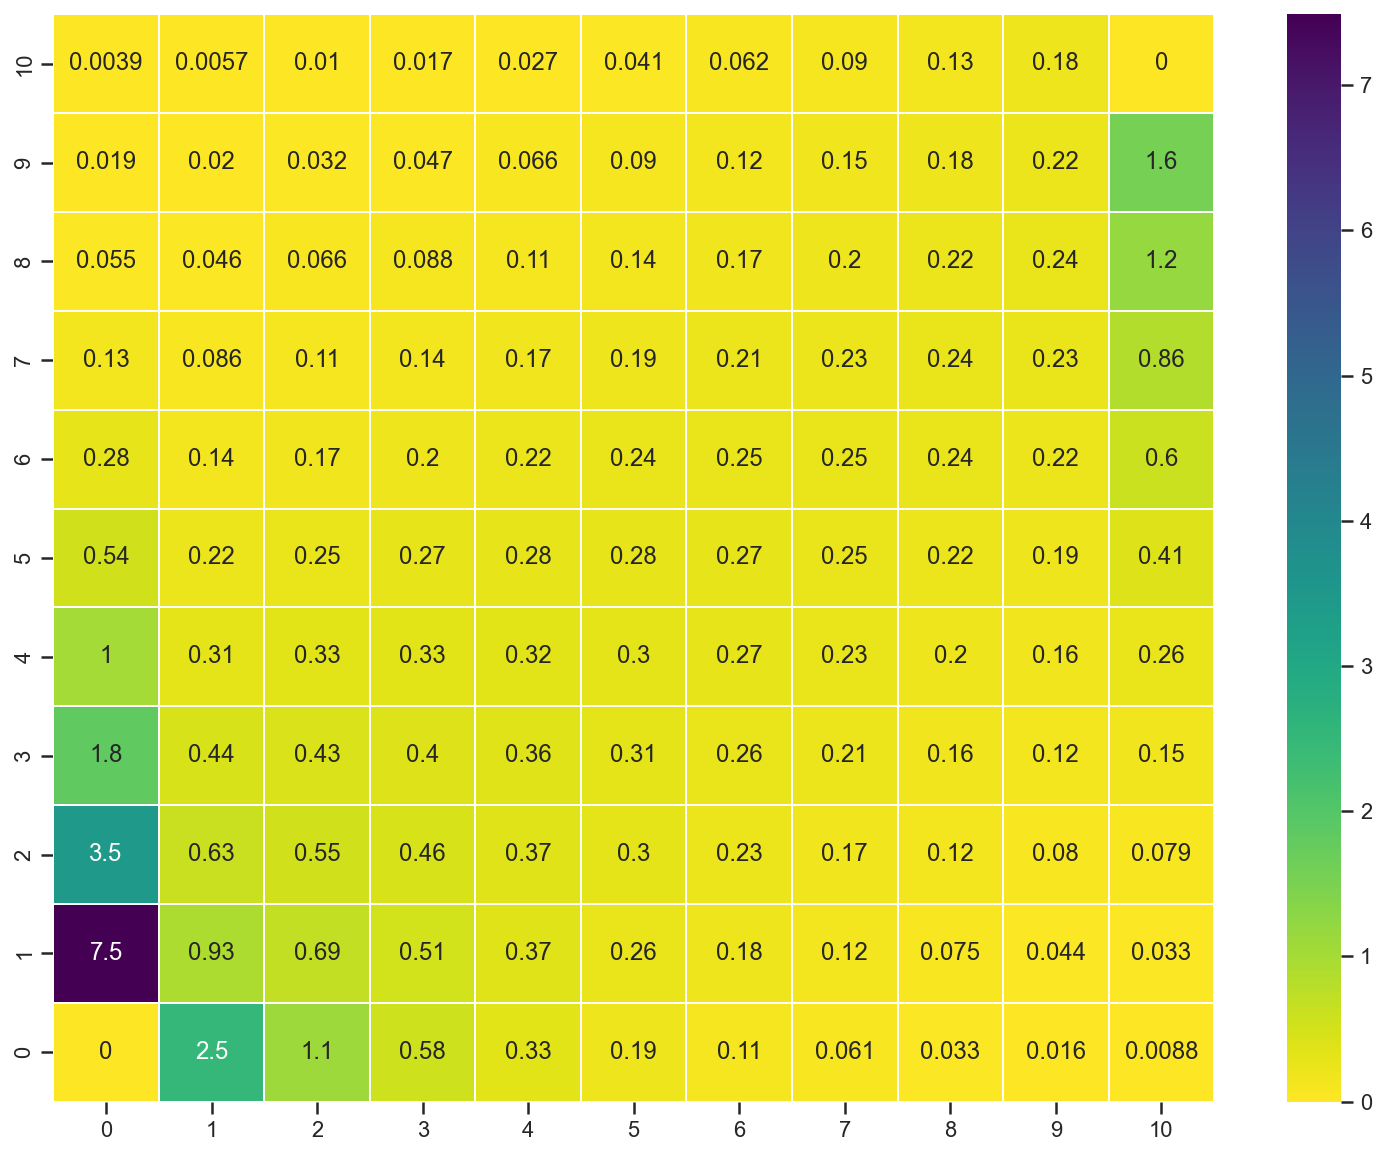

In [21]:
plt.subplots(1, 1, figsize=(13, 10))
ax = sns.heatmap(im_expectation + a_expectation, cmap="viridis_r", 
                annot=True,
                linewidths=1,
                linecolor='white'
                )
ax.invert_yaxis()
plt.savefig(f"im_{n1}_{n1}_{m12}_{m12}_{split_t}_annot.pdf")
plt.savefig(f"im_{n1}_{n1}_{m12}_{m12}_{split_t}_annot.png")